In [1]:
import os
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils
from torchvision.datasets import ImageFolder

import cv2
import PIL
import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.functions import save_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"Using {device} now!")

Using cuda now!


In [3]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [8]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [9]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [10]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
312 	 torch.Size([128, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
62 	 torch.Size([128, 1, 32, 32])


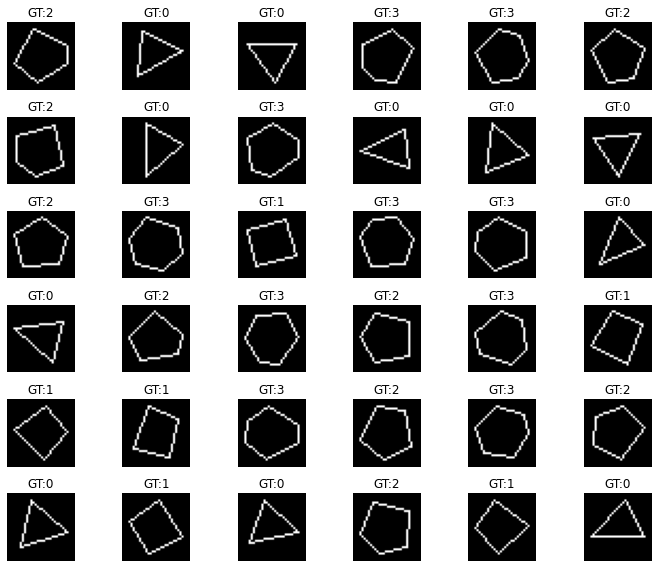

In [11]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(f"GT:{labels[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

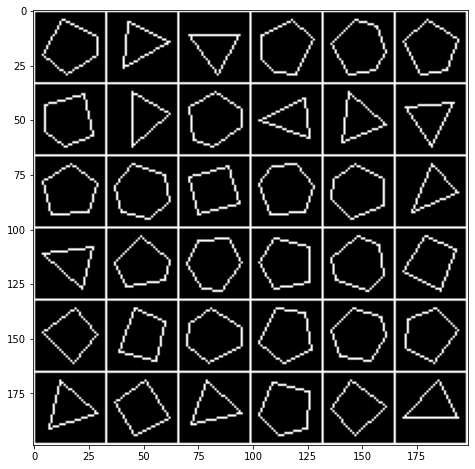

In [13]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))
plt.show()

In [27]:
def check_accuracy(test_model, loader):
    num_correct = 0
    num_samples = 0
    test_model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(loader):
            X = X.to(device, dtype=torch.float32)  # move to device, e.g. GPU
            Y = Y.to(device, dtype=torch.int)
            scores = test_model(X)
            num_correct += (scores.argmax(axis=1) == Y).sum()
            num_samples += len(scores)
        return float(num_correct) / num_samples

def train(model, optimizer, scheduler, loss_fn, train_loader, writer,
          check_fn, check_loaders, batch_step, epochs=2, log_every=10):
    check_loader_train = check_loaders['train']
    check_loader_val = check_loaders['val']
    iters = len(train_loader)
    for epoch in range(1, epochs + 1):
        tic = time.time()
        for batch_idx, (X, Y) in enumerate(train_loader):
            batch_step += 1
            model.train()
            X = X.to(device, dtype=torch.float32)
            Y = Y.to(device, dtype=torch.int64)
            scores = model(X)
            loss = loss_fn(scores, Y)
            writer.add_scalar('loss', loss.item(), batch_step)
            writer.add_scalar('lr', optimizer.param_groups[0]['lr'], batch_step)

            # back propagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(batch_step / iters)

            # check accuracy
            if batch_idx % log_every == 0:
                model.eval()
                train_acc = check_fn(model, check_loader_train)
                val_acc = check_fn(model, check_loader_val)
                writer.add_scalars('acc', {'train':train_acc, 'val':val_acc}, batch_step)
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tVal acc: {:.1f}%'.format(
                    epoch, batch_idx * batch_size, len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                           loss, 100. * val_acc))

        print('====> Epoch: {}\tTime: {}s'.format(epoch, time.time() - tic))

    return batch_step

In [15]:
model = models.my_ConvNeXt(in_chans=1, num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.05)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
loss_func = nn.CrossEntropyLoss()

In [12]:
# copy the following line to prompt line!
# tensorboard --logdir runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [16]:
writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

In [17]:
# reset train history
batch_step = 0

In [18]:
# Train and test!

check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

In [19]:
batch_step = train(model, optimizer, scheduler, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=60, log_every=50)

Epoch: 1 [0/40000 (0%)]	Loss: 1.39900	Val acc: 24.5%
Epoch: 1 [6400/40000 (16%)]	Loss: 1.36389	Val acc: 25.4%
Epoch: 1 [12800/40000 (32%)]	Loss: 1.32822	Val acc: 29.0%
Epoch: 1 [19200/40000 (48%)]	Loss: 1.31781	Val acc: 35.5%
Epoch: 1 [25600/40000 (64%)]	Loss: 1.28268	Val acc: 35.8%
Epoch: 1 [32000/40000 (80%)]	Loss: 1.27840	Val acc: 36.2%
Epoch: 1 [38400/40000 (96%)]	Loss: 1.30244	Val acc: 36.3%
====> Epoch: 1	Time: 13.020544052124023s
Epoch: 2 [0/40000 (0%)]	Loss: 1.26045	Val acc: 36.8%
Epoch: 2 [6400/40000 (16%)]	Loss: 1.24142	Val acc: 40.2%
Epoch: 2 [12800/40000 (32%)]	Loss: 1.21570	Val acc: 42.1%
Epoch: 2 [19200/40000 (48%)]	Loss: 1.17836	Val acc: 43.9%
Epoch: 2 [25600/40000 (64%)]	Loss: 1.15490	Val acc: 43.1%
Epoch: 2 [32000/40000 (80%)]	Loss: 1.15211	Val acc: 44.7%
Epoch: 2 [38400/40000 (96%)]	Loss: 1.13526	Val acc: 50.4%
====> Epoch: 2	Time: 12.461067199707031s
Epoch: 3 [0/40000 (0%)]	Loss: 1.13778	Val acc: 51.2%
Epoch: 3 [6400/40000 (16%)]	Loss: 1.11633	Val acc: 50.5%
Epoch: 3

In [26]:
writer.close()

In [20]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 90.68%


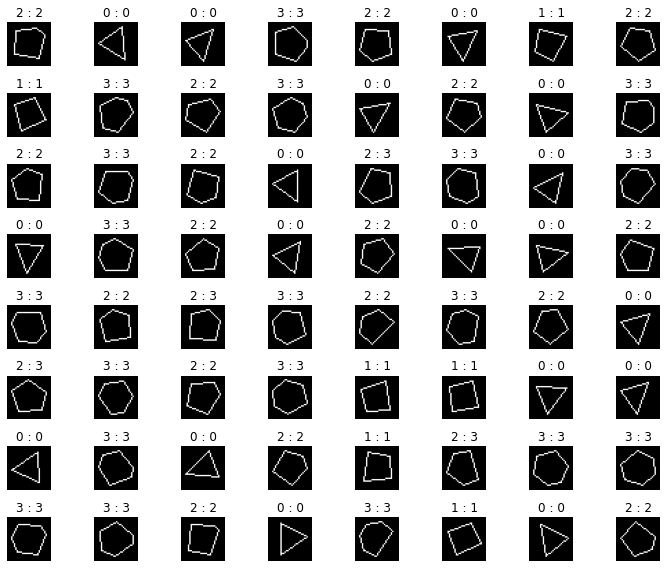

In [21]:
imgs, labels = next(iter(test_loader))
scores = model(imgs.to(device))
preds = scores.argmax(axis=1)

vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

In [22]:
# Save model

save_model(model, 'myconvnext', optimizer, acc=90)

Model parameters:
connection_layers.0.weight:	 torch.Size([8, 1])
connection_layers.0.bias:	 torch.Size([8])
connection_layers.1.weight:	 torch.Size([16, 8])
connection_layers.1.bias:	 torch.Size([16])
connection_layers.2.weight:	 torch.Size([32, 16])
connection_layers.2.bias:	 torch.Size([32])
norm_layers.0.weight:	 torch.Size([8])
norm_layers.0.bias:	 torch.Size([8])
norm_layers.0.running_mean:	 torch.Size([8])
norm_layers.0.running_var:	 torch.Size([8])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([8])
norm_layers.1.bias:	 torch.Size([8])
norm_layers.1.running_mean:	 torch.Size([8])
norm_layers.1.running_var:	 torch.Size([8])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([16])
norm_layers.2.bias:	 torch.Size([16])
norm_layers.2.running_mean:	 torch.Size([16])
norm_layers.2.running_var:	 torch.Size([16])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([8])
stages.0.0.dwconv

In [23]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-5, weight_decay=0.1)

save_path = 'saved_models/90_polygen_myconvnext_2022_01_21_17_59_58.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

In [28]:
new_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(new_optimizer, T_0=1, T_mult=2)

In [ ]:
# re-train

batch_step = train(new_model, new_optimizer, new_scheduler, loss_func, train_loader, writer,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=20, log_every=50)

Epoch: 1 [0/40000 (0%)]	Loss: 0.25499	Val acc: 94.9%
Epoch: 1 [6400/40000 (16%)]	Loss: 0.29473	Val acc: 96.1%
Epoch: 1 [12800/40000 (32%)]	Loss: 0.28429	Val acc: 94.5%
Epoch: 1 [19200/40000 (48%)]	Loss: 0.28602	Val acc: 93.0%
Epoch: 1 [25600/40000 (64%)]	Loss: 0.32804	Val acc: 95.8%
Epoch: 1 [32000/40000 (80%)]	Loss: 0.27900	Val acc: 95.8%
Epoch: 1 [38400/40000 (96%)]	Loss: 0.27973	Val acc: 95.7%
====> Epoch: 1	Time: 12.570460319519043s
Epoch: 2 [0/40000 (0%)]	Loss: 0.26630	Val acc: 95.7%
Epoch: 2 [6400/40000 (16%)]	Loss: 0.27468	Val acc: 95.3%
Epoch: 2 [12800/40000 (32%)]	Loss: 0.31258	Val acc: 95.4%
Epoch: 2 [19200/40000 (48%)]	Loss: 0.26108	Val acc: 95.2%
Epoch: 2 [25600/40000 (64%)]	Loss: 0.29590	Val acc: 96.4%
Epoch: 2 [32000/40000 (80%)]	Loss: 0.29769	Val acc: 95.8%
Epoch: 2 [38400/40000 (96%)]	Loss: 0.28016	Val acc: 95.7%
====> Epoch: 2	Time: 12.41758108139038s
Epoch: 3 [0/40000 (0%)]	Loss: 0.27694	Val acc: 95.2%
Epoch: 3 [6400/40000 (16%)]	Loss: 0.27530	Val acc: 94.7%
Epoch: 3 

In [44]:
new_model.eval()
test_acc = check_accuracy(new_model, test_loader)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 96.98%


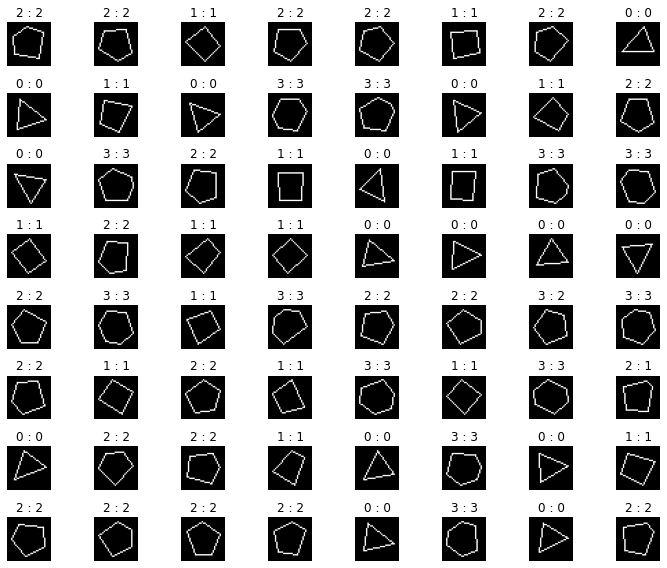

In [45]:
imgs, labels = next(iter(test_loader))
scores = new_model(imgs.to(device))
preds = scores.argmax(axis=1)

vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

In [46]:
save_model(new_model, 'myconvnext', new_optimizer, acc=97)

Model parameters:
connection_layers.0.weight:	 torch.Size([8, 1])
connection_layers.0.bias:	 torch.Size([8])
connection_layers.1.weight:	 torch.Size([16, 8])
connection_layers.1.bias:	 torch.Size([16])
connection_layers.2.weight:	 torch.Size([32, 16])
connection_layers.2.bias:	 torch.Size([32])
norm_layers.0.weight:	 torch.Size([8])
norm_layers.0.bias:	 torch.Size([8])
norm_layers.0.running_mean:	 torch.Size([8])
norm_layers.0.running_var:	 torch.Size([8])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([8])
norm_layers.1.bias:	 torch.Size([8])
norm_layers.1.running_mean:	 torch.Size([8])
norm_layers.1.running_var:	 torch.Size([8])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([16])
norm_layers.2.bias:	 torch.Size([16])
norm_layers.2.running_mean:	 torch.Size([16])
norm_layers.2.running_var:	 torch.Size([16])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([8])
stages.0.0.dwconv